# Samsung DS-KAIST
- 강의: 신진우 교수님
- 조교: 이한국 (hankook.lee@kaist.ac.kr)

본 실습은 https://www.tensorflow.org/tutorials/images/segmentation 에 기반하여 작성되었습니다.

---

# Image segmentation

Image classification은 이미지 하나에 대해서 하나의 label 예측하는 반면, image segmentation은 모든 pixel에 대해서 각 pixel이 어떤 category에 속하는지 분류하는 문제입니다. category는 semantic category가 될 수도 있고, instance를 구분하는 정보가 될 수도 있습니다. Image segmentation은 medical imaging, self-driving 등에 활용될 수 있습니다.

본 실습에서는 segmentation을 위한 neural network를 직접 구현해보는 과정을 연습을 해볼 것입니다.

In [1]:
import os
os.environ['CUDA_VISIBLE_DEVICES'] = '0' # We do not use GPU for this lecture

import tensorflow as tf

from IPython.display import clear_output
import matplotlib.pyplot as plt

## 1. Dataset: Oxford-IIIT Pet Dataset
본 실습에서는 [Oxford-IIIT Pet Dataset](https://www.robots.ox.ac.uk/~vgg/data/pets/)을 사용할 것입니다. 해당 데이터셋에는 다양한 애완동물에 대한 이미지가 포함되어 있습니다. 하나의 이미지는 한 마리의 애완동물만 포함하고 있으며, 각 pixel들은 다음과 같이 3개의 category로 분류되어 있습니다. (일반적인 semantic segmentation 데이터셋의 경우, 하나의 이미지에 여러 물체/동물이 있을 수 있고, 따라서 더 많은 수의 category를 가지고 있습니다.)
- Class 1 : Pixel belonging to the pet.
- Class 2 : Pixel bordering the pet.
- Class 3 : None of the above/ Surrounding pixel.

위의 데이터셋은 [TensorFlow datasets](https://github.com/tensorflow/datasets) package에 포함되어 있습니다. 아래의 코드를 사용하면 자동으로 다운로드됩니다. `info`에는 해당 데이터셋과 관련된 정보가 들어가며, `dataset`에는 실제 데이터가 들어가게 됩니다.

In [2]:
import tensorflow_datasets as tfds
tfds.disable_progress_bar()

dataset, info = tfds.load('oxford_iiit_pet:3.*.*', with_info=True)

In [3]:
info

tfds.core.DatasetInfo(
    name='oxford_iiit_pet',
    version=3.2.0,
    description='The Oxford-IIIT pet dataset is a 37 category pet image dataset with roughly 200
images for each class. The images have large variations in scale, pose and
lighting. All images have an associated ground truth annotation of breed.',
    homepage='http://www.robots.ox.ac.uk/~vgg/data/pets/',
    features=FeaturesDict({
        'file_name': Text(shape=(), dtype=tf.string),
        'image': Image(shape=(None, None, 3), dtype=tf.uint8),
        'label': ClassLabel(shape=(), dtype=tf.int64, num_classes=37),
        'segmentation_mask': Image(shape=(None, None, 1), dtype=tf.uint8),
        'species': ClassLabel(shape=(), dtype=tf.int64, num_classes=2),
    }),
    total_num_examples=7349,
    splits={
        'test': 3669,
        'train': 3680,
    },
    supervised_keys=('image', 'label'),
    citation="""@InProceedings{parkhi12a,
      author       = "Parkhi, O. M. and Vedaldi, A. and Zisserman, A. and Ja

In [4]:
print('# of training samples:', info.splits['train'].num_examples)
print('# of test samples:', info.splits['test'].num_examples)

# of training samples: 3680
# of test samples: 3669


### 1.1. Data Preprocessing

아래의 코드를 이용하여 이미지를 preprocessing하게 됩니다. 본 실습에서는 편의성을 위해 모든 이미지를 128x128 크기로 만들어줍니다.
- `normalize`: 이미지를 0과 1 사이의 실수값으로 만들어주고, segmentation label을 0~2의 정수값으로 만들어주는 함수입니다.
- `load_image_train`: 학습할 때 data preprocessing을 위한 함수입니다. Data augmentation 목적으로 random하게 좌우로 이미지를 반전시켜줍니다.
- `load_image_test`: 평가할 때 data preprocessing을 위한 함수입니다. 이 때에는 좌우 반전이 필요 없으므로, resizing과 normalization만 시켜줍니다.

In [5]:
def normalize(input_image, input_mask):
    input_image = tf.cast(input_image, tf.float32) / 255.0
    input_mask -= 1
    return input_image, input_mask

In [6]:
@tf.function
def load_image_train(datapoint):
    input_image = tf.image.resize(datapoint['image'], (128, 128))
    input_mask = tf.image.resize(datapoint['segmentation_mask'], (128, 128))

    if tf.random.uniform(()) > 0.5:
        input_image = tf.image.flip_left_right(input_image)
        input_mask = tf.image.flip_left_right(input_mask)

    input_image, input_mask = normalize(input_image, input_mask)

    return input_image, input_mask

In [7]:
def load_image_test(datapoint):
    input_image = tf.image.resize(datapoint['image'], (128, 128))
    input_mask = tf.image.resize(datapoint['segmentation_mask'], (128, 128))

    input_image, input_mask = normalize(input_image, input_mask)

    return input_image, input_mask

### 1.2. Data Pipeline

다운로드한 `dataset['train']`과 `dataset['test']`는 [tf.data](https://www.tensorflow.org/guide/data?hl=en) 모듈에 정의된 [tf.data.Dataset](https://www.tensorflow.org/api_docs/python/tf/data/Dataset)입니다. [tf.data](https://www.tensorflow.org/guide/data?hl=en)의 API를 이용하여 batch를 효율적으로 구성할 수 있습니다. 아래는 pipeline에 사용된 함수들에 대한 간단한 설명입니다. 자세한 설명은 링크를 통해 확인하시길 바랍니다.
- [map](https://www.tensorflow.org/api_docs/python/tf/data/Dataset#map): dataset에 있는 각 data point 하나마다 함수를 적용해주는 함수입니다.
- [shuffle](https://www.tensorflow.org/api_docs/python/tf/data/Dataset#shuffle): `BUFFER_SIZE` 만큼의 데이터를 buffer에 넣은 후 shuffle합니다.
- [batch](https://www.tensorflow.org/api_docs/python/tf/data/Dataset#batch): `BATCH_SIZE` 만큼의 데이터를 하나의 batch로 묶어줍니다.
- [repeat](https://www.tensorflow.org/api_docs/python/tf/data/Dataset#repeat): 해당 데이터셋을 이용할 때, 끝나지 않고 계속해서 batch를 구성할 수 있도록 해줍니다.

In [8]:
TRAIN_LENGTH = info.splits['train'].num_examples
BATCH_SIZE = 64
BUFFER_SIZE = 1000
STEPS_PER_EPOCH = TRAIN_LENGTH // BATCH_SIZE

In [9]:
train = dataset['train'].map(load_image_train, num_parallel_calls=tf.data.experimental.AUTOTUNE)
test = dataset['test'].map(load_image_test)

In [10]:
train_dataset = train.cache().shuffle(BUFFER_SIZE).batch(BATCH_SIZE).repeat()
train_dataset = train_dataset.prefetch(buffer_size=tf.data.experimental.AUTOTUNE)
test_dataset = test.batch(BATCH_SIZE)

### 1.3. Data Display

- `display`: image / ground-truth segmentation mask / predicted mask 를 보여주는 함수입니다. 2개를 넣을 경우 
- `take(n)`: 데이터셋에서 `n`개의 데이터를 가져오는 함수입니다.

In [11]:
def display(display_list):
    plt.figure(figsize=(15, 15))

    title = ['Input Image', 'True Mask', 'Predicted Mask']

    for i in range(len(display_list)):
        plt.subplot(1, len(display_list), i+1)
        plt.title(title[i])
        plt.imshow(tf.keras.preprocessing.image.array_to_img(display_list[i]))
        plt.axis('off')
    plt.show()

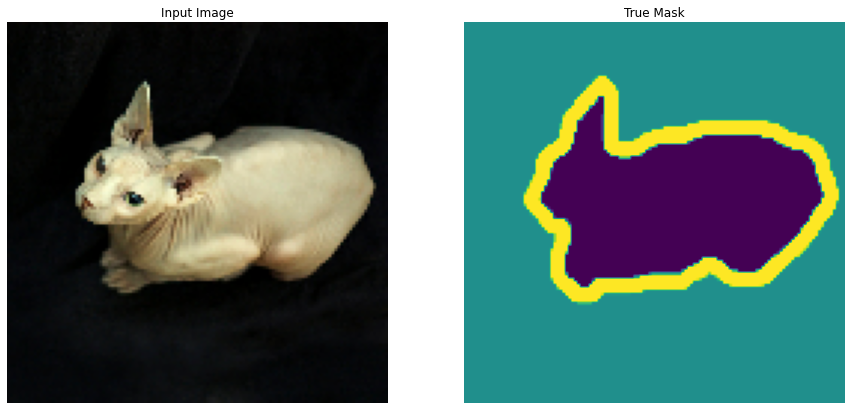

In [12]:
for image, mask in train.take(1):
    sample_image, sample_mask = image, mask
display([sample_image, sample_mask])

## 2. Model Design

Segmentation을 하기 위해서는 pixel마다 prediction을 할 수 있어야 합니다. 본 과정에서는 neural network $f$가 $x\in\mathbb{R}^{128\times 128\times 3}$의 RGB 이미지를 입력으로 받고, $f(x)\in\mathbb{R}^{128\times 128\times C}$ 형태의 값을 출력하게 됩니다. 여기서 $C$는 category의 수로, 본 과정에서는 $C=3$이 됩니다. 해당 출력값 $f(x)$는 모든 pixel $(i,j)$에 대해 category별 점수로 표현됩니다. 따라서, argmax 함수로 최종 segmentation mask를 assign할 수 있습니다.

In [13]:
OUTPUT_CHANNELS = 3

### 2.1. Backbone Architecture: MobileNetV2

위에서 언급된 segmentation network $f$를 설계하기 위해서는 일반적으로 모든 layer가 convolution으로 구성되어 있는 FCN(fully convolutional network)이 사용됩니다. FCN architecture들은 보통 classification network를 변형하여 사용합니다. 모델 학습시에도 scratch(random initialization)부터 학습하는 것이 아닌, ImageNet classification dataset에서 학습(pre-trained)된 parameter를 가져와서 fine-tuning하는 방식을 사용합니다. 이는 모델의 최종 성능과 학습 속도에 아주 큰 영향을 미칩니다. 본 실습에서는 상대적으로 가벼운 [MobileNetV2](https://arxiv.org/abs/1801.04381) architecture를 기반으로 segmentation architecture를 설계할 것입니다. 해당 모델의 경우 [tf.keras.applications](https://www.tensorflow.org/versions/r2.0/api_docs/python/tf/keras/applications)에 정의되어 있어, 쉽게 사용할 수 있습니다. 본 과정에서는 학습을 좀 더 빠르게 하기 위해 MobileNetV2 부분의 parameter는 학습하지 않고, segmentation을 위해 새롭게 추가되는 layer만 학습할 것입니다.

아래의 `backbone_features`는 MobileNetV2의 다양한 resolution의 feature map을 가져와주는 역할을 합니다. 자세한 사용법은 아래 예제를 참고하세요.

In [14]:
backbone = tf.keras.applications.MobileNetV2(input_shape=[128, 128, 3], include_top=False)

# Use the activations of these layers
layer_names = [
    'block_1_expand_relu',   # 64x64
    'block_3_expand_relu',   # 32x32
    'block_6_expand_relu',   # 16x16
    'block_13_expand_relu',  # 8x8
    'block_16_project',      # 4x4
]
layers = [backbone.get_layer(name).output for name in layer_names]

# Create the feature extraction model
backbone_features = tf.keras.Model(inputs=backbone.input, outputs=layers)
backbone_features.trainable = False

### 2.2. Segmentation Module Implementation

이번 섹션에서는 backbone architecture가 주어졌을 때, 어떻게 segmentation module을 구현하는지에 대해 다룰 것입니다. 모델 구현 편의를 위해 [Keras](https://keras.io)를 사용할 예정입니다. 

- [tf.keras.Model](https://www.tensorflow.org/api_docs/python/tf/keras/Model): Keras의 핵심 모듈입니다. inputs과 outputs에 해당되는 tensor를 지정해주면, 그 사이에 연결된 layer들을 묶어주고, 학습에 필요한 method(`compile`, `fit` 등)를 사용할 수 있게 해줍니다. 
- [tf.keras.Sequential](https://www.tensorflow.org/api_docs/python/tf/keras/Sequential): 여러개의 layer를 연속으로 사용하게 되는 경우에 사용됩니다. 여러 layer를 묶어서 하나의 layer로 만들어줍니다.
- [tf.keras.layers.Conv2D](https://www.tensorflow.org/api_docs/python/tf/keras/layers/Conv2D): Convolutional layer 하나를 만들어줍니다.
- [tf.keras.layers.UpSampling2D](https://www.tensorflow.org/api_docs/python/tf/keras/layers/UpSampling2D): 이미지 형태의 input을 upsampling해주는 layer입니다.

In [15]:
def build_example_model():
    # 모델의 input shape을 결정합니다.
    inputs = tf.keras.layers.Input(shape=[128, 128, 3])

    # backbone 모델로부터 feature map을 가져옵니다.
    features = backbone_features(inputs)
    
    # 사용할 feature map을 하나 골라줍니다.
    # 4번째 feature map은 8x8의 resolution을 가집니다.
    x = features[3]
    
    # 해당 feature map을 기반으로 8x8 크기의 segmentation prediction mask를 만들어주는 CNN을 만들어줍니다.
    convnet = tf.keras.Sequential(layers=[
        tf.keras.layers.Conv2D(16, 3, padding='same'),
        tf.keras.layers.BatchNormalization(),
        tf.keras.layers.ReLU(),
        tf.keras.layers.Conv2D(OUTPUT_CHANNELS, 3, padding='same'),
    ])
    x = convnet(x)
    
    # 8x8 resolution을 출력값을 bilinear interpolation을 이용해서 128x128 크기로 만들어줍니다.
    upsample = tf.keras.layers.UpSampling2D(
        size=(16, 16), interpolation='bilinear')
    x = upsample(x)

    # x를 최종 출력값으로 가지는 모델을 만들어줍니다.
    return tf.keras.Model(inputs=inputs, outputs=x)

## 3. Training Our Segmentation Model

이제, 위에서 정의된 segmentation network를 학습하고, 평가할 차례입니다. 이 과정에서도 마찬가지로 [Keras](https://keras.io)를 적극 활용할 것입니다.

### 3.1. Compile

이제, 위에서 정의한 함수를 이용하여 모델을 실제로 만들고, `compile`합니다. 여기서 `compile`은 `tf.keras.Model`을 학습할 때 사용할 optimizer, loss, 그리고 evaluation에 사용할 metric을 설정해줍니다. 본 과정에서는 segmentation을 다루는데, 이는 pixel마다 classification 문제를 푸는 것과 같으므로 loss로 `losses.SparseCategoricalCrossentropy(from_logits=True)`를 사용합니다. 해당 loss를 사용하면, 출력값은 category에 해당하는 channel의 값이 높아지도록 학습됩니다. 아래는 visualization을 위한 함수에 대한 설명입니다.

- `create_mask`: 모델의 출력값으로부터 실제 segmentation mask를 만드는 함수입니다.
- `show_predictions`: `model`을 이용하여 실제 데이터에 대해 prediction을 하고, 이를 visualization하는 함수입니다.
- `tf.keras.utils.plot_model`: 모델의 구조를 visualization합니다. 각 layer의 input과 output의 shape를 통해 모델이 잘 정의가 되었는지 확인할 수 있습니다.

In [41]:
# model = build_example_model()
# model = build_deeper_model()
# model = build_highres_model()
model = build_multires_model()
# model = build_deconvnet()
# model = build_unet()

ValueError: A `Concatenate` layer requires inputs with matching shapes except for the concat axis. Got inputs shapes: [(None, 16, 16, 320), (None, 128, 128, 576), (None, 16, 16, 192)]

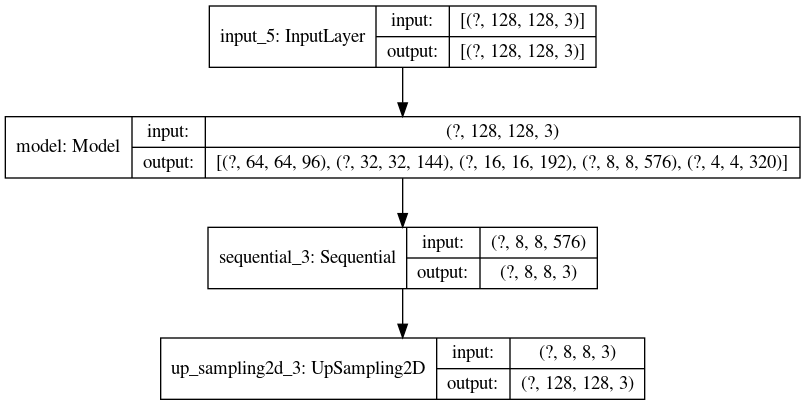

In [44]:
model.compile(optimizer='adam',
              loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
              metrics=['accuracy'])

def create_mask(pred_mask):
    pred_mask = tf.argmax(pred_mask, axis=-1)
    pred_mask = pred_mask[..., tf.newaxis]
    return pred_mask[0]

def show_predictions(dataset=None, num=1):
    if dataset:
        for image, mask in dataset.take(num):
            pred_mask = model.predict(image)
            display([image[0], mask[0], create_mask(pred_mask)])
    else:
        display([sample_image, sample_mask,
                 create_mask(model.predict(sample_image[tf.newaxis, ...]))])
        
tf.keras.utils.plot_model(model, show_shapes=True)

`show_predictions` 함수를 이용하여 현재 모델의 prediction을 관측합니다. 현재는 모델이 학습이 되지 않은 상태이기 때문에, prediction이 true mask와 많이 다른것을 볼 수 있습니다.

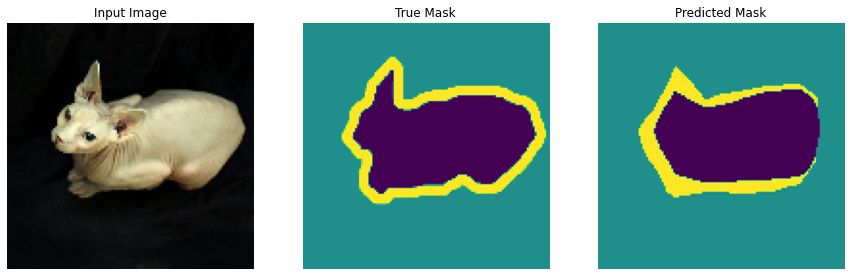

In [45]:
show_predictions()

### 3.2. Training

`model.fit` 함수를 이용하면 모델을 쉽게 학습할 수 있습니다. 아래의 `DisplayCallback`에 정의된 `on_epoch_end` 함수는 학습 도중, training epoch이 끝날 때마다 호출되는 함수입니다. IPython의 `clear_output` 함수를 이용해 이전에 display된 내용을 지우고, 새로운 결과를 visualization합니다.

In [28]:
class DisplayCallback(tf.keras.callbacks.Callback):
    def on_epoch_end(self, epoch, logs=None):
        clear_output(wait=True)
        show_predictions()
        print ('\nSample Prediction after epoch {}\n'.format(epoch+1))

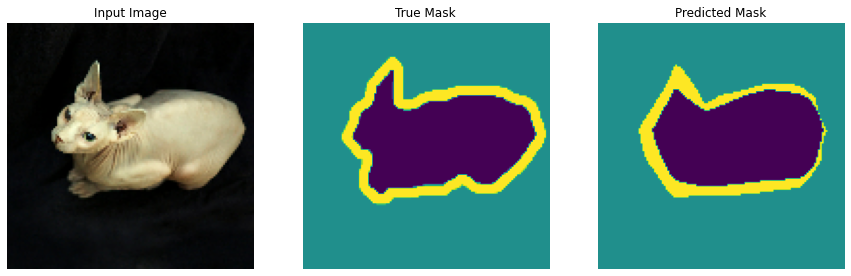


Sample Prediction after epoch 10

57/57 [==============================] - 2s 32ms/step - loss: 0.2336 - accuracy: 0.8931 - val_loss: 0.3183 - val_accuracy: 0.8669


In [46]:
EPOCHS = 10
VAL_SUBSPLITS = 10
VALIDATION_STEPS = info.splits['test'].num_examples // BATCH_SIZE // VAL_SUBSPLITS

model_history = model.fit(train_dataset, epochs=EPOCHS,
                          steps_per_epoch=STEPS_PER_EPOCH,
                          validation_steps=VALIDATION_STEPS,
                          validation_data=test_dataset,
                          callbacks=[DisplayCallback()])

## 4. Evaluation

이제, 학습한 모델을 평가할 것입니다. 먼저, 학습 과정에서 epoch에 따른 training loss와 validation loss를 보여주고, 학습이 **정량적**으로 잘 되고 있는지를 확인합니다. Pixel accuracy에 대해서도 마찬가지로 확인해줍니다.

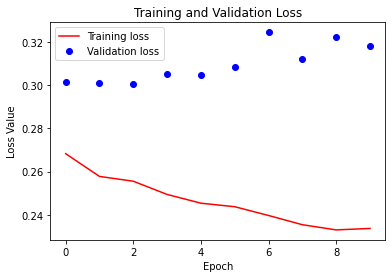

In [47]:
loss = model_history.history['loss']
val_loss = model_history.history['val_loss']

epochs = range(EPOCHS)

plt.figure()
plt.plot(epochs, loss, 'r', label='Training loss')
plt.plot(epochs, val_loss, 'bo', label='Validation loss')
plt.title('Training and Validation Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss Value')
plt.legend()
plt.show()

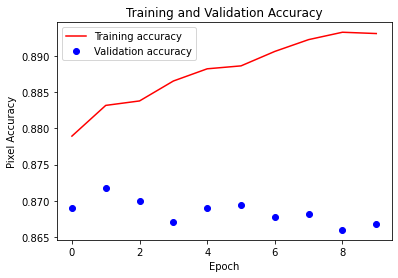

Best Validation Accuracy: 87.18


In [48]:
acc = model_history.history['accuracy']
val_acc = model_history.history['val_accuracy']

epochs = range(EPOCHS)

plt.figure()
plt.plot(epochs, acc, 'r', label='Training accuracy')
plt.plot(epochs, val_acc, 'bo', label='Validation accuracy')
plt.title('Training and Validation Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Pixel Accuracy')
plt.legend()
plt.show()

print('Best Validation Accuracy: %.2f' % (max(model_history.history['val_accuracy'])*100,))

학습이 **정성적**으로 잘 되었는지에 대한 평가는 test sample에 대해서 어떻게 예측하는지를 직접 확인하는 방식으로 이루어집니다.

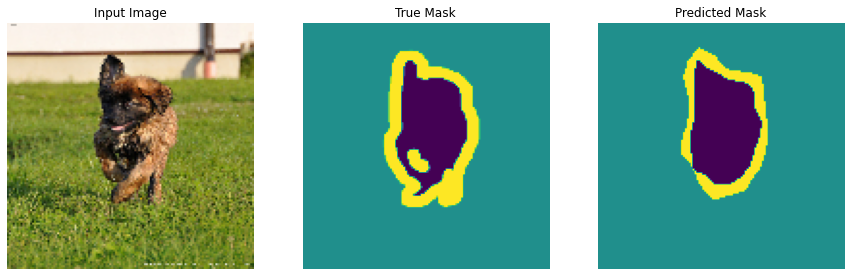

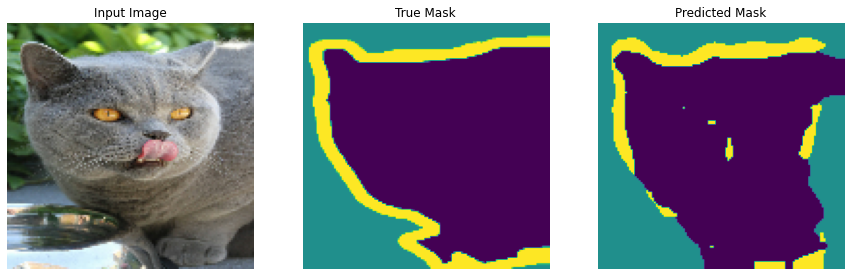

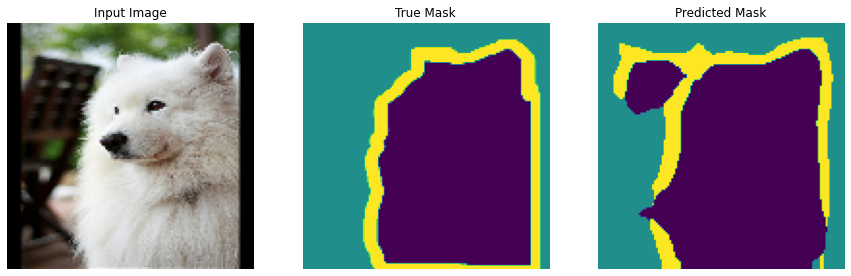

In [35]:
show_predictions(test_dataset, 3)

## Tasks

Segmentation architecture를 설계하기 위한 기본적인 내용은 전부 다루었습니다. 이제, 위의 모델을 여러가지 방향으로 개선시켜보면서 실습이 진행될 것입니다. 각 task에서는 어떤 방향으로 architecture를 설계할 것인지에 대한 간단한 내용이 포함되어 있습니다. 그 내용을 바탕으로,
1. Section 2.2의 `build_example_model` 함수와 비슷한 역할을 하는 함수를 정의합니다. Skeleton 코드는 주어져 있습니다.
2. Section 3의 내용을 기반으로 모델을 다시 학습합니다.
3. Section 4의 내용을 기반으로 모델을 다시 평가합니다. 그리고 이전 모델과 어떤 변화가 있는지 관측합니다.

**NOTE.** CPU를 사용하기 때문에, filter의 갯수(=width)는 16~32 정도로만 사용하세요.

### Task 1. Deeper Architecture

`build_example_model` 함수를 보면, MobileNetV2 architecture의 8x8 feature map으로부터 2개의 convolutional layer를 사용합니다. 더 많은 수의 layer를 사용하면 성능의 개선될까요? 비슷하게, convolutional layer의 width를 늘리면 어떨까요? 아래의 함수를 수정하고, 학습(Section 3)과 평가(Section 4)를 다시 진행해보세요. 진행 시 아래 부분은 수정을 해야합니다.
```python
model = build_example_model() # 수정 전
model = build_deeper_model()  # 수정 후
```

- Q) layer를 하나 더 사용하거나, width를 16에서 32로 늘려보세요.
- Q) (Optional) 다른 조합도 고려해보세요.
- Q) (Optional) architecture에 따른 성능 차이를 확인해보세요. 

In [36]:
def build_deeper_model():
    # 모델의 input shape을 결정합니다.
    inputs = tf.keras.layers.Input(shape=[128, 128, 3])

    # backbone 모델로부터 feature map을 가져옵니다.
    features = backbone_features(inputs)
    
    # 사용할 feature map을 하나 골라줍니다.
    # 4번째 feature map은 8x8의 resolution을 가집니다.
    x = features[3]
    
    # 해당 feature map을 기반으로 8x8 크기의 segmentation prediction mask를 만들어주는 CNN을 만들어줍니다.
    ## FILL YOUR CODE ##
    convnet = tf.keras.Sequential(layers=[
        tf.keras.layers.Conv2D(32, 3, padding='same'),
        tf.keras.layers.BatchNormalization(),
        tf.keras.layers.ReLU(),
        tf.keras.layers.Conv2D(32, 3, padding='same'),
        tf.keras.layers.BatchNormalization(),
        tf.keras.layers.ReLU(),
        tf.keras.layers.Conv2D(OUTPUT_CHANNELS, 3, padding='same'),
    ])

    ####################
    x = convnet(x)
    
    # 8x8 resolution을 출력값을 bilinear interpolation을 이용해서 128x128 크기로 만들어줍니다.
    upsample = tf.keras.layers.UpSampling2D(
        size=(16, 16), interpolation='bilinear')
    x = upsample(x)

    # x를 최종 출력값으로 가지는 모델을 만들어줍니다.
    return tf.keras.Model(inputs=inputs, outputs=x)

### Task 2. Use High-resolution Feature Maps

이전 모델에서는 8x8 resolution으로 mask를 예측한 후에, bilinear interpolation(16x)을 통해 128x128 resolution의 mask를 만들었습니다. 여기서, 너무 큰 scaling factor(16x)로 bilinear interpolation을 하였기 때문에, 예측한 mask가 정교하지 않아 성능이 나오지 않은 것일 수 있습니다. 좀 더 high-resolution feature map를 이용해보면 어떨까요?

- Q) 16x16 resolution의 feature map을 가져와서, example 혹은 Task 1과 비슷하게 설계해보세요.
- Q) (Optional) 다른 resolution의 feature map도 사용해보세요.
- Q) (Optional) 어떤 resolution을 사용하는 것이 성능이 가장 높은가요? 또, resolution에 따른 장단점을 생각해보세요.

In [31]:
def build_highres_model():
    # 모델의 input shape을 결정합니다.
    inputs = tf.keras.layers.Input(shape=[128, 128, 3])

    # backbone 모델로부터 feature map을 가져옵니다.
    features = backbone_features(inputs)
    
    # 사용할 feature map을 하나 골라줍니다.
    ## FILL YOUR CODE ##
    x = features[2]
    ####################

    # 해당 feature map을 기반으로 segmentation prediction mask를 만들어주는 CNN을 만들어줍니다.
    ## FILL YOUR CODE ##
    convnet = tf.keras.Sequential(layers=[
        tf.keras.layers.Conv2D(16, 3, padding='same'),
        tf.keras.layers.BatchNormalization(),
        tf.keras.layers.ReLU(),
        tf.keras.layers.Conv2D(OUTPUT_CHANNELS, 3, padding='same'),
    ])
    ####################
    x = convnet(x)
    
    # 출력값을 bilinear interpolation을 이용해서 128x128 크기로 만들어줍니다.
    ## FILL YOUR CODE ##
    upsample = tf.keras.layers.UpSampling2D(
        size=(8, 8), interpolation='bilinear')
    x = upsample(x)
    ####################

    # x를 최종 출력값으로 가지는 모델을 만들어줍니다.
    return tf.keras.Model(inputs=inputs, outputs=x)

### Task 3. Use Multi-resolution Feature Maps (FCN)

각 resolution(4x4, 8x8, ..., 64x64)마다 장단점이 있다면, 어떻게 architecture를 설계하면 될까요? 가장 간단한 방법은 여러 resolution을 동시에 사용하는 것입니다. 아래는 [FCN](https://arxiv.org/abs/1411.4038) (Long et al., 2015) 논문에서 사용한 architecture 그림입니다. FCN-8s를 보시면, 3가지 다른 resolution을 가지는 feature map을 upsampling한 후에 합쳐서 사용하였습니다. 저희 코드를 예시로 설명드리면, 
1. `features`로부터 여러 종류(4x4, 8x8, 16x16)의 feature map을 추출합니다.
2. `tf.keras.layers.UpSampling2D` 함수를 이용하여 같은 resolution(16x16)을 가지도록 upsampling해줍니다.
3. `tf.keras.layers.Concatenate` 함수를 이용해서 여러 feature map을 하나로 합쳐줍니다. 사용법은 다음과 같습니다. `concat_layer = tf.keras.layers.Concatenate()`를 선언해 준 뒤, concatenation할 feature maps를 `y = concat_layer([x1, x2, x3])` 형태로 넣어주시면 됩니다. 자세한 사용법은 [여기](https://www.tensorflow.org/api_docs/python/tf/keras/layers/Concatenate)를 참고하세요.
4. `convnet`을 통과시키고, bilinear interpolation을 이용해 128x128 resolution의 prediction을 만듧니다.

<img src="http://deeplearning.net/tutorial/_images/fcn.png">

- Q) 4x4, 8x8, 16x16 feature maps를 전부 16x16로 만들어서 사용해보세요. 이 전과 비교했을 때, 성능의 차이가 어떤가요?
- Q) 32x32, 64x64도 사용하는것이 좋을까요? 한번 확인해보시고, 장단점을 분석해보세요.

In [43]:
def build_multires_model():
    # 모델의 input shape을 결정합니다.
    inputs = tf.keras.layers.Input(shape=[128, 128, 3])

    # backbone 모델로부터 feature map을 가져옵니다.
    features = backbone_features(inputs)
    
    # 사용할 feature map을 여러개 고르고, 각 feature map을 같은 크기로 upsampling 해줍니다.
    ## FILL YOUR CODE ##
    feature_4x4 = tf.keras.layers.UpSampling2D(size=(4, 4), interpolation='bilinear')(features[4])
    feature_8x8 = tf.keras.layers.UpSampling2D(size=(2, 2), interpolation='bilinear')(features[3])
    multiple_features = [feature_4x4, feature_8x8, features[2]]
    ####################
    
    # 같은 크기로 만들어진 feature map을 합쳐줍니다.
    concat = tf.keras.layers.Concatenate(axis=-1)
    ## FILL YOUR CODE ##
    x = concat(multiple_features)
    ####################

    # 해당 feature map을 기반으로 segmentation prediction mask를 만들어주는 CNN을 만들어줍니다.
    ## FILL YOUR CODE ##
    convnet = tf.keras.Sequential(layers=[
        tf.keras.layers.Conv2D(16, 3, padding='same'),
        tf.keras.layers.BatchNormalization(),
        tf.keras.layers.ReLU(),
        tf.keras.layers.Conv2D(OUTPUT_CHANNELS, 3, padding='same'),
    ])
    ####################
    x = convnet(x)
    
    # 출력값을 bilinear interpolation을 이용해서 128x128 크기로 만들어줍니다.
    ## FILL YOUR CODE ##
    upsample = tf.keras.layers.UpSampling2D(
        size=(8, 8), interpolation='bilinear')
    x = upsample(x)
    ####################

    # x를 최종 출력값으로 가지는 모델을 만들어줍니다.
    return tf.keras.Model(inputs=inputs, outputs=x)

### Task 4. Use Convolution Transpose

이번 task에서는, upsampling (bilinear interpolation) 대신 convolution transpose를 이용하여 high-resolution mask를 만들어볼 것입니다. `tf.keras.layers.Conv2DTranspose` 함수를 사용하면, transposed convolution filter를 사용하면서 resolution를 늘릴 수 있습니다. 아래는 예시이고, 더 자세한 내용은 [여기](https://www.tensorflow.org/api_docs/python/tf/keras/layers/Conv2DTranspose)를 참고하세요.
```python
# x's shape = [8, 8, 512]
layer = tf.keras.layers.Conv2DTranspose(256, 3, strides=2, padding='same')
y = layer(x) # y's shape = [16, 16, 256]
```

위의 코드를 이용해서, 아래 그림처럼 8x8 feature map에서 시작하여 128x128 크기까지 resolution을 키워보세요.

<img src="https://miro.medium.com/max/1400/1*LW8Anre45o9nfamxIVTY8Q.png">

Q) 8x8 resolution map부터 시작해서 총 4개의 `Conv2DTranspose`와 마지막 `Conv2D`을 사용해서 만들어보세요.
Q) bilinear interpolation만 사용하는 모델(`build_example_model`)과 어떤 차이가 있나요?

In [ ]:
def build_deconvnet():
    # 모델의 input shape을 결정합니다.
    inputs = tf.keras.layers.Input(shape=[128, 128, 3])

    # backbone 모델로부터 feature map을 가져옵니다.
    features = backbone_features(inputs)
    
    # 사용할 feature map을 하나 골라줍니다.
    # 4번째 feature map은 8x8의 resolution을 가집니다.
    x = features[3]
    
    # 8x8 feature map을 시작으로 UpSampling2D 없이 128x128 크기까지 mask를 만들어줍니다.
    # 일반적으로, resolution이 커질수록 width(=num_filters)를 줄이는것이 좋습니다.
    ## FILL YOUR CODE ##

    ####################
    x = deconvnet(x)
    
    # x를 최종 출력값으로 가지는 모델을 만들어줍니다.
    return tf.keras.Model(inputs=inputs, outputs=x)

### Task 5. U-Net Implementation

이번 task에서는 [U-Net](https://lmb.informatik.uni-freiburg.de/people/ronneber/u-net/) (Ronneberger et al., 2015) architecture를 구현해볼 것입니다. U-Net에서는 그림과 같이, convolution transpose와 concatenation을 적절히 활용하는 모델입니다. Task 3과 4에서 배웠던 지식을 활용하여 U-Net을 구현해보세요.

- `Conv2DTranspose`의 channel 수는 16으로 고정해주세요.
- 4x4를 `Conv2DTranspose`를 이용해서 8x8로 만들고, 이를 기존의 `backbone_features`의 8x8와 concatentaion해주세요.
- 위를 비슷한 방식으로 반복하여 128x128까지 만들어보세요.

<img src="https://lmb.informatik.uni-freiburg.de/people/ronneber/u-net/u-net-architecture.png">

In [ ]:
def build_unet():
    ## FILL YOUR CODE ##

    ####################

### Optional Tasks

이번 과정에서 배웠던 내용을 토대로, 아래의 architecture들도 구현이 가능합니다. 시간이 남으신 분들은 아래 architecture도 구현해보세요!

#### [PSPNet](https://arxiv.org/abs/1612.01105) (Zhao et al., 17)

<img src="https://mblogthumb-phinf.pstatic.net/MjAxNzAzMDhfMTcx/MDAxNDg4OTM4MzgwOTY3.5-y7_UfPSHsTnuHdRsKeOa6238ZNtL0EyXCDnQBMngAg.6JaNVcQu3azK4Xun9rMu2Z0MIzMsP6Rphnjbo0jEov4g.PNG.sogangori/3-Figure3-1.png?type=w800">

#### [Deeplab v3](https://arxiv.org/abs/1706.05587) (Chen et al., 17)
이 architecture의 경우 dilated convolution을 사용합니다. 이는 `tf.keras.layers.Conv2D`을 선언할 때, `dilation_rate` 인자를 이용하여 만들 수 있습니다.

<img src="https://www.oreilly.com/library/view/hands-on-image-processing/9781789343731/assets/1aa5b349-5a66-456a-8afa-080a7b07a525.png">